# Virtual Synthesis

In [12]:
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import numpy as np
import pandas as pd
import sounddevice as sd
import helpers as hp
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
import librosa
import librosa.feature
import imp 
import os, random

imp.reload(hp)
sr=48000

# Synthesizer Module Paramters:

In [144]:
class Synth_Module():
    def __init__(self,params):
        buff=SoundBuffer(channels=1)
        length=1
        if params.isNoise==1:
            buff = noise.bln(params.getOscType(),params.getLength(),30,
                150000,channels=1) 
        else:
            buff = Osc(str(params.getOscType()), freq=list(params.getPitches()),
                       channels=1).play(params.getLength()) 

        buff=buff.adsr(a=params.A, d=params.D, s=params.S, r=params.R)
        bpfilter=params.getBandPass()
        buff.frames = helpers.butter_bandpass_filter(buff.frames,bpfilter[0],bpfilter[1], 
                                                     sr, order=bpfilter[2])
        #a high pass 
        buff.frames = helpers.butter_bandpass_filter(buff.frames,80,15000, 
                                                     sr, order=8)
        self.buff=buff

| Parameters       | Value Range     | Notes and Constraints                            |
|------------------|-----------------|--------------------------------------------------|
| Attack           | 0\-3            | A\-D\-S\-R values relative                       |
| Decay            | 0\-3            | relative to A\-S\-R                              |
| Sustain          | 0\-3            | relative to A\-D\-R                              |
| Release          | 0\-3            | relative to A\-D\-S                              |
| OSC type         | sine,square,saw | \-                                               |
| IsNoise          | boolean         | generate noise using \\newline cloud of waveform |
| Length           | 0\-1 second     | \-                                               |
| StartTime        | 0\-1 second     | Length\+Start$<$1                                |
| Amplitude        | 0\.1\-1         | 1 = max amplitude                                |
| Pitches\(notes\) | list of pitches | range of C0\(16\.35hz\) to B9                    |
| HP filter Cutoff | 0\-20000hz      | \-                                               |
| LP filter Cutoff | 20000hz\-HP     | never lower than HP cutoff                       |
| Filter Order     | 4,8,16          | butterworth filter order                         |

# Creating Sounds via Random Synth Parameters

{'oscType': 1, 'isNoise': 0, 'A': 1, 'D': 0, 'S': 3, 'R': 0, 'pitch_0': 80, 'pitch_1': 80, 'pitch_2': 104, 'pitch_3': 0, 'bpCutLow': 56, 'bpCutHigh': 83, 'bpOrder': 1, 'amplitude': 0, 'start': 2, 'length': 0, 'em_prob': 0.75, 'fm_prob': 0.5} 

{'oscType': 0, 'isNoise': 0, 'A': 2, 'D': 3, 'S': 3, 'R': 0, 'pitch_0': 26, 'pitch_1': 44, 'pitch_2': 88, 'pitch_3': 48, 'bpCutLow': 118, 'bpCutHigh': 118, 'bpOrder': 2, 'amplitude': 1, 'start': 7, 'length': 1, 'em_prob': 0.75, 'fm_prob': 0.5} 

{'oscType': 0, 'isNoise': 0, 'A': 3, 'D': 2, 'S': 2, 'R': 3, 'pitch_0': 20, 'pitch_1': 108, 'pitch_2': 64, 'pitch_3': 64, 'bpCutLow': 72, 'bpCutHigh': 111, 'bpOrder': 2, 'amplitude': 3, 'start': 9, 'length': 0, 'em_prob': 0.75, 'fm_prob': 0.5} 

{'oscType': 0, 'isNoise': 1, 'A': 1, 'D': 3, 'S': 1, 'R': 1, 'pitch_0': 12, 'pitch_1': 4, 'pitch_2': 72, 'pitch_3': 96, 'bpCutLow': 26, 'bpCutHigh': 71, 'bpOrder': 1, 'amplitude': 3, 'start': 3, 'length': 5, 'em_prob': 0.75, 'fm_prob': 0.5} 

-1.474373590129158 (4

/home/asalimi/miniconda3/lib/python3.7/site-packages/librosa/display.py:709: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


CPU times: user 96.8 ms, sys: 16.5 ms, total: 113 ms
Wall time: 109 ms


<Figure size 576x360 with 0 Axes>

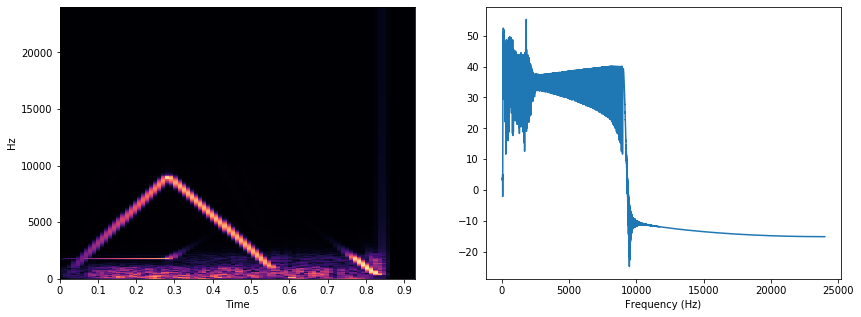

In [16]:
%%time
#generate 1 sound
import imp
imp.reload(pg)
imp.reload(hp)

out = dsp.buffer(length=1,channels=1)
params = []
stack_num = 4
params = [pg.RandomParams() for i in range(stack_num)]
for p in params:
    print(p.__dict__, "\n")
sound = pg.ensemble(params)

z = librosa.feature.rms(sound)
print(np.sum(sound),sound.shape)
hp.specShow(sound)
Audio(sound,rate = sr, autoplay = True)

# Mutation

{'oscType': 0, 'isNoise': 1, 'A': 1, 'D': 3, 'S': 1, 'R': 2, 'pitch_0': 98, 'pitch_1': 84, 'pitch_2': 104, 'pitch_3': 0, 'bpCutLow': 49, 'bpCutHigh': 54, 'bpOrder': 2, 'amplitude': 1, 'start': 1, 'length': 3, 'em_prob': 0.25, 'fm_prob': 0.25}
{'oscType': 0, 'isNoise': 0, 'A': 1, 'D': 2, 'S': 2, 'R': 3, 'pitch_0': 92, 'pitch_1': 76, 'pitch_2': 48, 'pitch_3': 0, 'bpCutLow': 22, 'bpCutHigh': 91, 'bpOrder': 1, 'amplitude': 1, 'start': 2, 'length': 2, 'em_prob': 0.75, 'fm_prob': 0.25}
{'oscType': 1, 'isNoise': 1, 'A': 1, 'D': 1, 'S': 2, 'R': 2, 'pitch_0': 78, 'pitch_1': 88, 'pitch_2': 48, 'pitch_3': 0, 'bpCutLow': 41, 'bpCutHigh': 97, 'bpOrder': 2, 'amplitude': 2, 'start': 9, 'length': 0, 'em_prob': 0.75, 'fm_prob': 0.75}
{'oscType': 0, 'isNoise': 1, 'A': 3, 'D': 0, 'S': 3, 'R': 2, 'pitch_0': 52, 'pitch_1': 28, 'pitch_2': 40, 'pitch_3': 0, 'bpCutLow': 20, 'bpCutHigh': 89, 'bpOrder': 1, 'amplitude': 3, 'start': 6, 'length': 3, 'em_prob': 0.25, 'fm_prob': 0.25}


<Figure size 576x360 with 0 Axes>

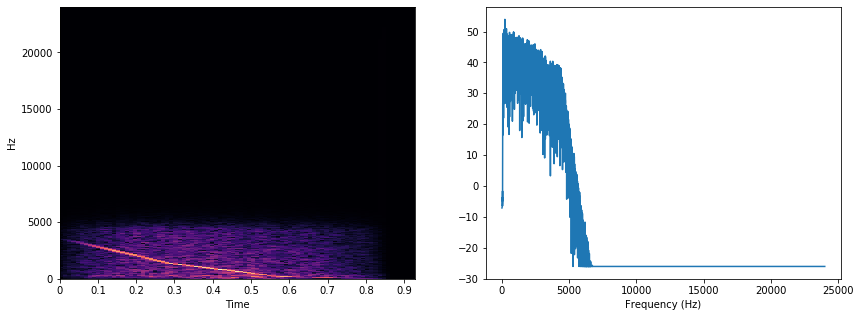

In [275]:
pm = [p.mutate(e=0.001, t=1) for p in params]
for p in pm:
    print(p.__dict__)
hp.specShow(pg.ensemble(params))
Audio(pg.ensemble(pm),rate=sr, autoplay=True)


### We can make random noise.
- But how do we select ones that sound like drums?
- We need a virtual ear!
    - Recognizes drums from not-drums
    - Given a drum, it can categorize the type of drum

### How do We Represent Sounds?

In [27]:
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from feature_extraction import pytorch_models as pm
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
from feature_extraction import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import optuna
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
spec=torchaudio.functional.spectrogram
db_name="sample_swap_free_final"
drum_df=pd.concat([miru.audioFrames(db_name="radar",loadCache=True, path = "./feature_extraction/drum_dbs/"),
                   miru.audioFrames(db_name="sample_swap",path = "./feature_extraction/drum_dbs/",loadCache=True)])
noise_df=miru.audioFrames(db_name="noise",loadCache=True, path = "./feature_extraction/drum_dbs/")
dLabels, dUniques=pd.factorize(drum_df["label"].tolist())
ndLabels, ndUniques=pd.factorize(noise_df["label"].tolist())

drum_df.loc[:,"label_num"]=dLabels
noise_df.loc[:,"label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])

y=drum_df.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])

all_frames=pd.concat([drum_df,noise_df],sort=True).reset_index(drop=True)

loading data base from ./feature_extraction/drum_dbs/radar ./feature_extraction/drum_dbs/radar.dill
loading data base from ./feature_extraction/drum_dbs/sample_swap ./feature_extraction/drum_dbs/sample_swap.dill
loading data base from ./feature_extraction/drum_dbs/noise ./feature_extraction/drum_dbs/noise.dill
label
clap                401
electronic_hits     235
hat                1275
kick               1334
noise               168
rim                  82
shake               116
snare              1035
tom                 167
voc                  73
Name: path, dtype: int64


kick
torch.Size([30, 20])
[1.         0.8802643  0.691561   0.49434108 0.36240318 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


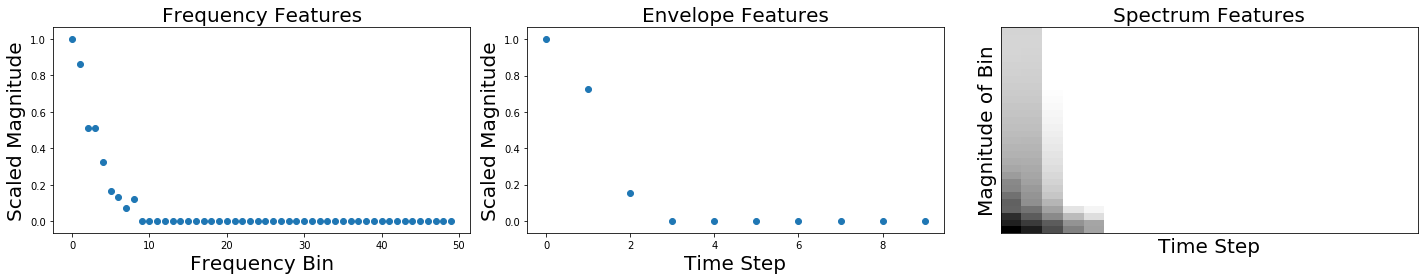

In [122]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        s= self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()
        freq=s
        freq[torch.isnan(freq)]=0
        freq=freq[0]
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
ds=pm.audioDataset(pd.concat([all_frames],sort=False),"./",task="dvn",)
# sample = ds[np.random.randint(len(drum_df))]
sample={"signal":sample["signal"],"label":sample["label"],"path":sample["path"],"drum_type":sample["drum_type"]}
print(sample["drum_type"])
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,)
        sf=ft.detach().numpy()
        ft=ft.detach().numpy()
        print(ft[0])
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)
Audio(sample["signal"],rate=SR,autoplay=True)


### How can we learn from these features?
- Need a virtual ear to make quick decisions
    - Decision 1: Drum vs Not Drum
    - Decision 2: Different types of drums

### Difficulties:


### Model Types:
- Two Phased Ears
   - Decision 1, then Decision 2

- Mixed Model Ears:
    - 